# Denoising Autoencoder
Generate the autoencoder to denoise our compressed images

In [1]:
import tensorflow.keras as keras
from keras import layers
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
from imblearn.over_sampling import ADASYN
from sklearn.utils import shuffle
import json
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
data = pd.read_pickle('./data/images_df_numerical.pkl')
classes = data["Species"].unique()
number_of_classes = classes.size

# Alleiniges undersampling wird keinen Sinn machen, da wir extrem wenig Datenpunkte overall haben
def resample(resampler) -> tuple[np.array, np.array]:
    X, y = data['data'], data['Species']
    X, y = np.stack(X).astype(np.uint8), y.to_numpy().astype(np.uint8)
    X_resampled, y_resampled = resampler.fit_resample(X, y)

    print(f"{resampler}: ", pd.Series(y_resampled, dtype=pd.UInt8Dtype()).value_counts())

    X_resampled, y_resampled = shuffle(X_resampled, y_resampled, random_state=1)

    return X_resampled, y_resampled

# oversampling
#adasyn = ADASYN()
#X, y = resample(adasyn)

X, y = data['data'], data['Species']
X, y = np.stack(X).astype(np.uint8), y.to_numpy().astype(np.uint8)

In [3]:
image_size = X[0].size
samples = X.size
with open("./data/meta.json","r") as file:  # get metadata for images from file generated from import nb
    image_meta = json.load(file) 
image_shape = (image_meta['h'],image_meta['w'],image_meta['c']) # hwc
print("Image has shape", image_shape)
# normalize to 0-1
X = X / 255.
X = X.reshape((-1,) + image_shape)

x_train, x_test = train_test_split(X,test_size=0.2)

Image has shape (65, 100, 3)


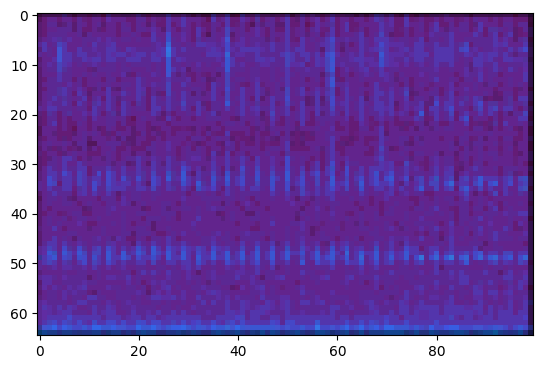

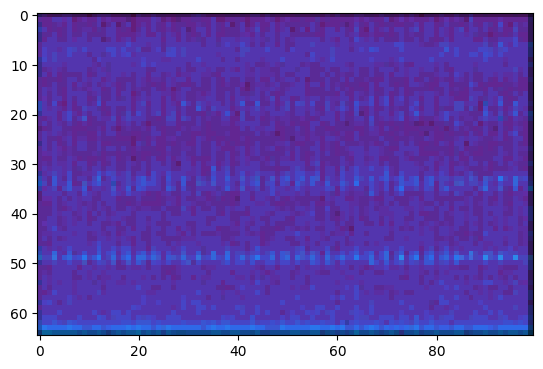

In [4]:
#print((X[10]*255.).astype('uint8'))
plt.imshow((X[0]*255.).astype('uint8'))
plt.show()
plt.imshow((x_test[0]*255.).astype('uint8'))

In [5]:
# cnn as en/decoder
shapes = image_shape
early_stopping = EarlyStopping(monitor='val_accuracy', patience=30, min_delta=0.001, start_from_epoch=15, restore_best_weights=True)
input_img = keras.Input(shape=shapes)

#v6
#x = layers.Conv2D(64, (7, 7), activation='relu', padding='same')(input_img)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
#x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = layers.MaxPooling2D((2, 2), padding='same')(x)
#x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(32, (2, 2), activation='relu', padding='same')(x)
#encoded = layers.Conv2D(32, (1, 1), activation='relu', padding='same')(x)

# Decoder
#x = layers.Conv2D(32, (1, 1), activation='relu', padding='same')(encoded)
#x = layers.Conv2D(32, (2, 2), activation='relu', padding='same')(x)
#x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = layers.UpSampling2D((2, 2))(x)
#x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#x = layers.UpSampling2D((2, 2))(x)
#x = layers.Conv2D(shapes[2], (7, 7), activation='sigmoid', padding='same')(x)
#add cropping layer to match shapes
#decoded=layers.Cropping2D(cropping=((0,0),(0,2)))(x)

#v8 (keras site)
#x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
#x = layers.MaxPooling2D((2, 2), padding="same")(x)
#x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
#x = layers.MaxPooling2D((2, 2), padding="same")(x)
#
# # Decoder
#x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
#x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
#x = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)
#decoded = layers.Cropping2D(cropping=((2,1),(0,0)))(x)

#v9 (tf site)
#x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(input_img)
#x = layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)(x)
#x = layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(x)
#x = layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same')(x)
#x = layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)
#decoded = layers.Cropping2D(cropping=((2,1),(0,0)))(x)

#v10 (keras blog)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x) #extra
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x) #extra


x = layers.UpSampling2D((2, 2))(x) #extra
x = layers.Cropping2D(cropping=((0,1),(0,1)))(x) #extra
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x) #extra
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
decoded = layers.Cropping2D(cropping=((2,1),(0,0)))(x)

autoencoder = keras.Model(input_img,decoded)
# compile autoencoder
autoencoder.compile(optimizer='adam', loss='binary_crossentropy',metrics=["accuracy"])
autoencoder.summary()

# train on data
autoencoder.fit(x_train,x_train,
                epochs=100,
                batch_size=100,
                shuffle=True,
                validation_split=0.2,
                callbacks=[early_stopping]
               )

# save model
autoencoder.save('./ae_files/denoise_autoencoder_cnn.keras')

2024-01-07 18:35:51.007241: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-01-07 18:35:51.007290: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-01-07 18:35:51.007305: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-01-07 18:35:51.007373: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-07 18:35:51.007411: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 65, 100, 3)]      0         
                                                                 
 conv2d (Conv2D)             (None, 65, 100, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 33, 50, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 33, 50, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 17, 25, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 25, 32)        9248  

2024-01-07 18:35:51.708354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


24/24 [==============================] - 3s 120ms/step - loss: 0.5941 - accuracy: 0.6885 - val_loss: 0.5590 - val_accuracy: 0.7142
Epoch 2/100
24/24 [==============================] - 2s 101ms/step - loss: 0.5439 - accuracy: 0.8092 - val_loss: 0.5357 - val_accuracy: 0.8388
Epoch 3/100
24/24 [==============================] - 2s 93ms/step - loss: 0.5321 - accuracy: 0.8535 - val_loss: 0.5300 - val_accuracy: 0.8693
Epoch 4/100
24/24 [==============================] - 2s 89ms/step - loss: 0.5291 - accuracy: 0.8725 - val_loss: 0.5286 - val_accuracy: 0.8849
Epoch 5/100
24/24 [==============================] - 2s 89ms/step - loss: 0.5282 - accuracy: 0.8807 - val_loss: 0.5280 - val_accuracy: 0.8915
Epoch 6/100
24/24 [==============================] - 2s 89ms/step - loss: 0.5277 - accuracy: 0.8834 - val_loss: 0.5276 - val_accuracy: 0.8911
Epoch 7/100
24/24 [==============================] - 2s 89ms/step - loss: 0.5273 - accuracy: 0.8842 - val_loss: 0.5273 - val_accuracy: 0.8833
Epoch 8/100
24/2

In [6]:
# predict some images
autoencoder = keras.saving.load_model('./ae_files/denoise_autoencoder_cnn.keras')
decoded_imgs = autoencoder.predict(x_test)
print(decoded_imgs[0].shape)
print((decoded_imgs[0]*255.))

24/24 [==============================] - 0s 14ms/step
(65, 100, 3)
[[[ 54.85959   27.559998  93.624535]
  [ 65.46136   27.027464  97.92336 ]
  [ 57.23168   26.720745  98.36283 ]
  ...
  [ 66.535545  21.572056  88.864655]
  [ 65.98473   19.804268  81.82724 ]
  [ 31.527092   9.788681  43.99688 ]]

 [[ 86.62036   41.43431  134.43306 ]
  [ 91.160095  51.01983  156.0167  ]
  [ 90.04954   47.03265  146.5816  ]
  ...
  [ 93.96013   42.958057 148.18875 ]
  [ 96.58856   40.226997 143.74393 ]
  [ 54.99245   23.41902   83.675835]]

 [[ 81.14513   42.584457 135.94446 ]
  [ 89.250946  53.341812 160.34685 ]
  [ 88.518     47.633385 150.16751 ]
  ...
  [ 92.11135   41.72472  151.87582 ]
  [ 97.245026  39.875942 148.08946 ]
  [ 55.353035  25.049551  93.378265]]

 ...

 [[ 64.23515   62.583958 163.51645 ]
  [ 67.77084   82.01339  201.41154 ]
  [ 67.779976  75.6062   198.86389 ]
  ...
  [ 71.2588    70.34009  191.8603  ]
  [ 70.4557    73.07397  187.41928 ]
  [ 37.288036  35.227505 101.51929 ]]

 [[ 49.

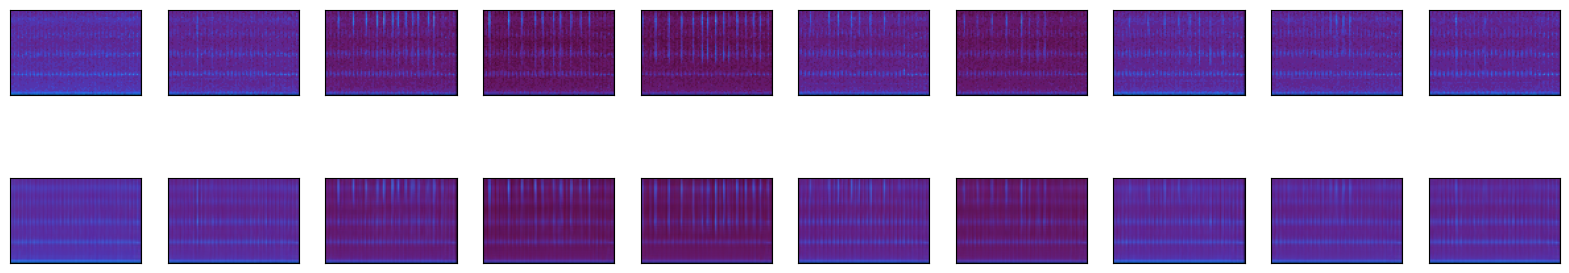

In [7]:
# display some of the images vs reconstruction
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    #plt.color()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    #plt.color()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig("test_autoencoder_cnn_reconstruction.png",dpi=600)
